In [12]:
import numpy as np
import matplotlib.pyplot as plt

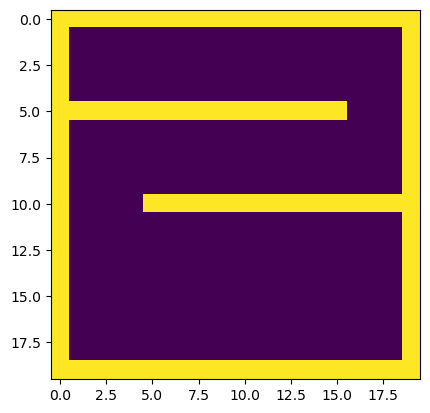

In [13]:
reality = -(np.pad(np.ones((18,18)),1)  - 1)
for ((wx1,wy1),(wx2,wy2)) in [((5,0),(5,15)),((10,5),(10,20))]:
    reality[wx1:wx2+1,wy1:wy2+1] = 1
    
plt.imshow(reality)
plt.show()

In [16]:
from collections import defaultdict
from functools import partial
import math

def map_cost(point):
    if reality[*point] == 0:
        return 1
    else:
        return math.inf

def l2(a,b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

def neighbourhood(p):
    x, y = p
    ps = [(x+1,y+1), (x+1,y  ), (x+1,y-1),
          (x  ,y-1), (x-1,y-1), (x-1,y  ),
          (x-1,y+1), (x  ,y+1)]
    return [p for p in ps if reality[*p] == 0]

def A_star(src, drn, heur):
    opn    = set([src])
    prev   = {}
    g      = defaultdict(lambda: math.inf)
    g[src] = 0
    f      = defaultdict(lambda: math.inf)
    f[src] = heur(src)

    print(opn)
    while opn:
        cur = sorted(opn, key=heur)[0]
        if cur == drn:
            return "found"

        opn.remove(cur)
        for i in neighbourhood(cur):
            score = g[cur] + l2(cur, i)

            if score < g[i]:
                prev[i] = cur
                g[i] = score
                f[i] = score + heur(i)
                opn.add(i)
            
    return opn
    
dst = (15,15)
A_star((0,3), dst, partial(l2, dst))

{(0, 3)}


'found'

In [3]:
robot_real = {
    "position": (2,3),
    "rotation": 0, #degrees
    "sonar_p": (.97, .1),
    "pos_p": (.99, .2),
    "rot_p": (1.04, .2)
}

robot_belief = {
    "position": (2,3),
    "rotation": 0, #degrees
    "sonar_p": (.99, .09),
    "pos_p": (1.02, .22),
    "rot_p": (1.0, .21)
}

In [4]:
import math

def sonar(real, step=.3):
    position = real["position"]
    r = real["rotation"]
    orientation = np.array([math.cos(r), math.sin(r)])

    dist = 0
    while(reality[int(position[0]),int(position[1])] != 1):
        dist += step
        position += orientation * step     
    
    return int(np.random.normal(*real["sonar_p"]) * dist)

sonar(robot_real)

3

In [3]:
import sched, time

class FakeRobot():
    def __init__(self, sched=True):
        self.speed = np.array([0.,0.])
        self.pos   = np.array([0.,0.])
        self.width = 0.5 # meters
        self.rotation = 0 # rads

        self.pos_history   = [np.array([0.,0.])]
        self.speed_history = [np.array([0.,0.])]

        if sched:
            scheduler = sched.scheduler()
            scheduler.enter(.1, 1, self._step, (scheduler,))
            scheduler.run()

    def go_diff(self, l, r):
        self.speed = np.array([l,r])
        self.speed_history += self.speed

    def stop(self):
        self.speed = np.array([0.,0.])
        self.speed_history += self.speed

    def _step(self, step_size=.1):
        scheduler.enter(.1, 1, self._step, (scheduler,))
        l, r  = self.speed
        L     = self.width
        theta = self.rotation

        # Turning radius in meters
        R = L * ((r+l)/(r-l))
        # Turning speed in radians
        w = (r-l) / L

        self.pos += np.array([R*math.sin(w*step_size+theta), R*math.cos(w*step_size+theta)])
        self.rotation += w*step_size
        self.pos_history.append(self.pos.copy())

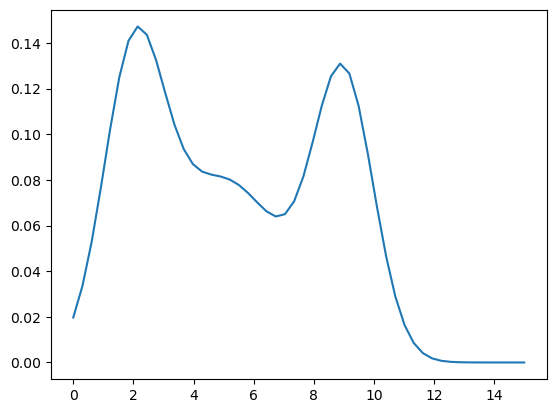

In [39]:
import numpy as np
import numpy.random as rand
from scipy.stats import norm
import matplotlib.pyplot as plt

n = 50

p_pdf = lambda x: .3*norm(2,1).pdf(x) + .4*norm(5,2).pdf(x) + .3*norm(9,1).pdf(x)
p_lut = np.array([p_pdf(x) for x in np.linspace(0,15,n)])

p = rand.choice(np.arange(n), n, p=p_lut/p_lut.sum())
plt.plot(np.linspace(0,15,n), p_lut)

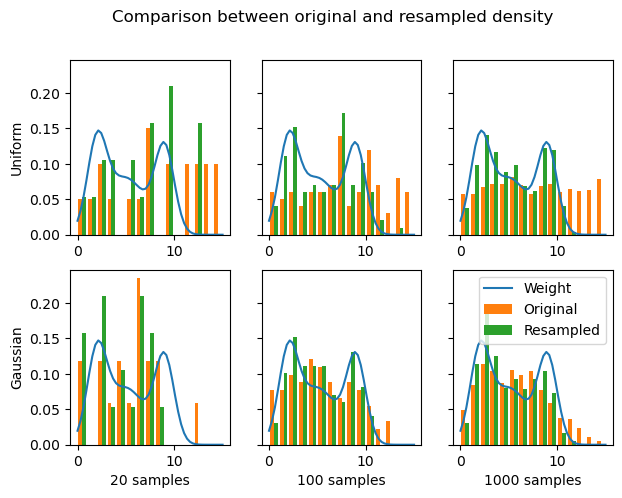

In [104]:
def sampler(X, p=0, size=50):
    samples = []
    r = rand.uniform(0, 1/size)
    c = p[0]
    i = 0
    for m in range(size-1):
        u = r + (m/size)
        while u > c:
            i += 1
            c += p[i-1]
        samples.append(X[i-1])
    return np.array(samples)

#sampler = rand.choice

fig, ax = plt.subplots(2,3, sharey=True, figsize=(7,5))

plt.suptitle("Comparison between original and resampled density")

for n, N in enumerate([20, 100, 1000]):
    q = rand.uniform(0,15,N)
    ax[0,0].set_ylabel("Uniform")
    ax[1, n].set_xlabel(f"{N} samples")
    ax[0, n].plot(np.linspace(0,15,50), p_lut)
    ax[0, n].hist([q,sampler(q, p=p_pdf(q)/p_pdf(q).sum(), size=N)], bins=range(16), density=True)

for n, N in enumerate([20, 100, 1000]):
    q = rand.normal(5,4,N)
    ax[1,0].set_ylabel("Gaussian")
    ax[1, n].plot(np.linspace(0,15,50), p_lut)
    ax[1, n].hist([q, sampler(q, p=p_pdf(q)/p_pdf(q).sum(), size=N)], bins=range(16), density=True)

plt.legend(["Weight", "Original","Resampled"])
plt.savefig("density.pdf")

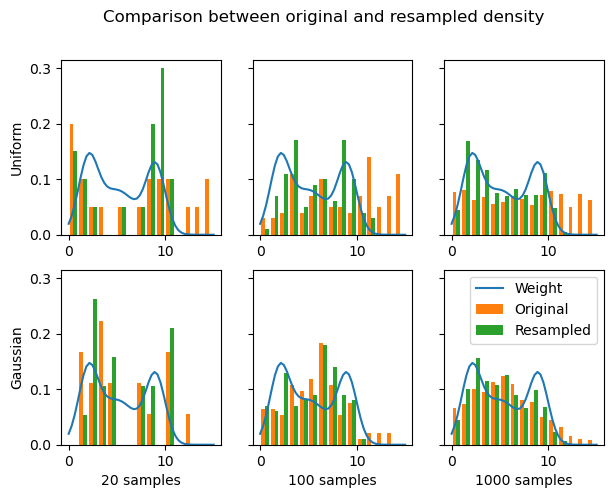

In [105]:
sampler = rand.choice

fig, ax = plt.subplots(2,3, sharey=True, figsize=(7,5))

plt.suptitle("Comparison between original and resampled density")

for n, N in enumerate([20, 100, 1000]):
    q = rand.uniform(0,15,N)
    ax[0,0].set_ylabel("Uniform")
    ax[1, n].set_xlabel(f"{N} samples")
    ax[0, n].plot(np.linspace(0,15,50), p_lut)
    ax[0, n].hist([q,sampler(q, p=p_pdf(q)/p_pdf(q).sum(), size=N)], bins=range(16), density=True)

for n, N in enumerate([20, 100, 1000]):
    q = rand.normal(5,4,N)
    ax[1,0].set_ylabel("Gaussian")
    ax[1, n].plot(np.linspace(0,15,50), p_lut)
    ax[1, n].hist([q, sampler(q, p=p_pdf(q)/p_pdf(q).sum(), size=N)], bins=range(16), density=True)

plt.legend(["Weight", "Original","Resampled"])
plt.savefig("density.pdf")

In [36]:
def linsearch(arr, a, s=0):
    while a > arr[s]:
        s += 1
    return s

def madow(weightArray):
    N = len(weightArray)
    csum = np.cumsum(weightArray)
    startingPoint = np.random.uniform(0, 1/N)
    return np.array([linsearch(csum, startingPoint+(j/N)) for j in range(N)])

madow(p_lut)

array([ 0,  1,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,
        5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,
        8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10])